In [367]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from keras.layers import Dense
from keras.models import Sequential
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
from tensorflow.keras.optimizers import Adam
import tensorflow_addons as tfa

In [368]:
listings_df = pd.read_csv('../data/processed/processed_listings.csv').dropna()
len(listings_df)

101364

In [369]:
listings_df.head()

,subtype,style,living_area,lot_dimensions,bedrooms,bathrooms,levels,location,listing_year,age,yard_area,listing_date,year_of_construction,price
0,2 Storey,2 storey,1191,4076,3,1,2,Capitale-Nationale,2020.0,16.0,2885,2020-12-01,2004,332500
1,Bungalow,Open area,1261,9500,2,1,1,Mauricie,2021.0,64.0,8239,2021-12-01,1957,265000
2,Townhouse,Unknown,1645,1360,3,1,3,Lachine,2021.0,15.0,0,2021-11-01,2006,612000
3,Bi-generation,Link,2024,17000,4,3,1,Capitale-Nationale,2021.0,2.0,14976,2021-12-01,2019,526500
4,Semi-detached,2 storey,2400,4471,4,2,2,Outaouais,2021.0,32.0,2071,2021-12-01,1989,360000


## Correlation Heat Map

In [370]:
sns.set_theme(style="white")

def plot_corr_map(df):
    # Compute the correlation matrix
    corr = df.corr()

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(8, 6))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

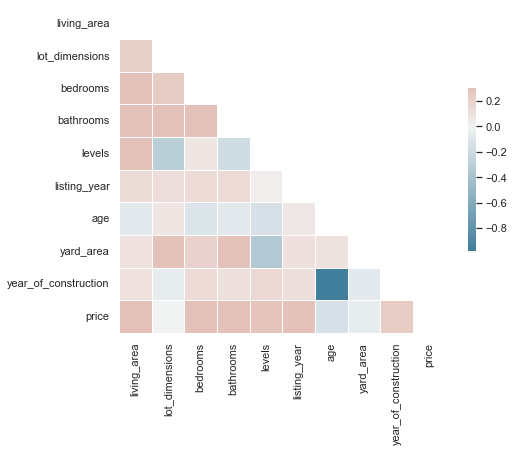

In [371]:
plot_corr_map(listings_df)

## Choosing columns

In [372]:
ordinal_cols = []
one_hot_cols = ['location', 'subtype']
numerical_cols = ['living_area', 'bedrooms', 'bathrooms', 'levels', 'yard_area', 'age', 'listing_year']
target_col = ['price']

In [373]:
listings_df = listings_df[ordinal_cols + one_hot_cols + numerical_cols + target_col]
listings_df.head()

,location,subtype,living_area,bedrooms,bathrooms,levels,yard_area,age,listing_year,price
0,Capitale-Nationale,2 Storey,1191,3,1,2,2885,16.0,2020.0,332500
1,Mauricie,Bungalow,1261,2,1,1,8239,64.0,2021.0,265000
2,Lachine,Townhouse,1645,3,1,3,0,15.0,2021.0,612000
3,Capitale-Nationale,Bi-generation,2024,4,3,1,14976,2.0,2021.0,526500
4,Outaouais,Semi-detached,2400,4,2,2,2071,32.0,2021.0,360000


## One Hot Encoding

In [374]:
def oh_encode(df_line, col, new_col, val):
    if df_line[col] == val:
        return df_line[new_col] + 1
    else:
        return df_line[new_col]

for col in one_hot_cols:
    for val in listings_df[col].unique():   
        new_col = str(val) + '_' + col
        listings_df[new_col] = 0
        listings_df[new_col] = listings_df.apply(oh_encode, args=(col, new_col, val), axis=1)

    listings_df = listings_df.drop(columns=[col])

In [375]:
listings_df.head()

,living_area,bedrooms,bathrooms,levels,yard_area,age,listing_year,price,Capitale-Nationale_location,Mauricie_location,...,St-Stanislas-De-Champlain_location,2 Storey_subtype,Bungalow_subtype,Townhouse_subtype,Bi-generation_subtype,Semi-detached_subtype,Split Level_subtype,1 1/2 Storey_subtype,Country Home_subtype,Condominium_subtype
0,1191,3,1,2,2885,16.0,2020.0,332500,1,0,...,0,1,0,0,0,0,0,0,0,0
1,1261,2,1,1,8239,64.0,2021.0,265000,0,1,...,0,0,1,0,0,0,0,0,0,0
2,1645,3,1,3,0,15.0,2021.0,612000,0,0,...,0,0,0,1,0,0,0,0,0,0
3,2024,4,3,1,14976,2.0,2021.0,526500,1,0,...,0,0,0,0,1,0,0,0,0,0
4,2400,4,2,2,2071,32.0,2021.0,360000,0,0,...,0,0,0,0,0,1,0,0,0,0


## Spliting Data

In [376]:
y = listings_df[target_col]
X = listings_df.drop(columns=target_col)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

## Ordinal Encoding

In [377]:
ordinal_encoders = {}

for col in ordinal_cols:
    ordinal_encoders[col] = OrdinalEncoder()
    ordinal_encoders[col].fit(listings_df[[col]])
    X_train[col] = ordinal_encoders[col].transform(X_train[[col]])
    X_test[col] = ordinal_encoders[col].transform(X_test[[col]])

X_train.head()

,living_area,bedrooms,bathrooms,levels,yard_area,age,listing_year,Capitale-Nationale_location,Mauricie_location,Lachine_location,...,St-Stanislas-De-Champlain_location,2 Storey_subtype,Bungalow_subtype,Townhouse_subtype,Bi-generation_subtype,Semi-detached_subtype,Split Level_subtype,1 1/2 Storey_subtype,Country Home_subtype,Condominium_subtype
99422,1002,3,1,1,948,91.0,2016.0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
27057,787,2,1,1,8060,42.0,2017.0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2308,2376,2,1,1,6294,12.0,2019.0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
34091,1253,3,1,2,3741,8.0,2015.0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
28849,1968,5,2,2,10158,22.0,2016.0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


## Scaling

In [378]:
scaled_cols = numerical_cols + ordinal_cols

In [379]:
scalers = {}

for col in scaled_cols:
    scalers[col] = MinMaxScaler()
    X_train[col] = scalers[col].fit_transform(X_train[[col]])
    X_test[col] = scalers[col].transform(X_test[[col]])

In [380]:
scale_target = True

if scale_target:
    target_scaler = MinMaxScaler()

    y_train = target_scaler.fit_transform(y_train)
    y_test = target_scaler.fit_transform(y_test)

X_train.head()

,living_area,bedrooms,bathrooms,levels,yard_area,age,listing_year,Capitale-Nationale_location,Mauricie_location,Lachine_location,...,St-Stanislas-De-Champlain_location,2 Storey_subtype,Bungalow_subtype,Townhouse_subtype,Bi-generation_subtype,Semi-detached_subtype,Split Level_subtype,1 1/2 Storey_subtype,Country Home_subtype,Condominium_subtype
99422,0.144798,0.4,0.000000,0.0,0.049473,0.049325,0.684211,0,0,0,...,0,0,0,0,0,0,0,0,0,1
27057,0.082659,0.2,0.000000,0.0,0.420624,0.023884,0.736842,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2308,0.541908,0.2,0.000000,0.0,0.328463,0.008307,0.842105,0,0,0,...,0,0,1,0,0,0,0,0,0,0
34091,0.217341,0.4,0.000000,0.5,0.195230,0.006231,0.631579,0,0,0,...,0,1,0,0,0,0,0,0,0,0
28849,0.423988,0.8,0.333333,0.5,0.530112,0.013499,0.684211,0,0,0,...,0,1,0,0,0,0,0,0,0,0


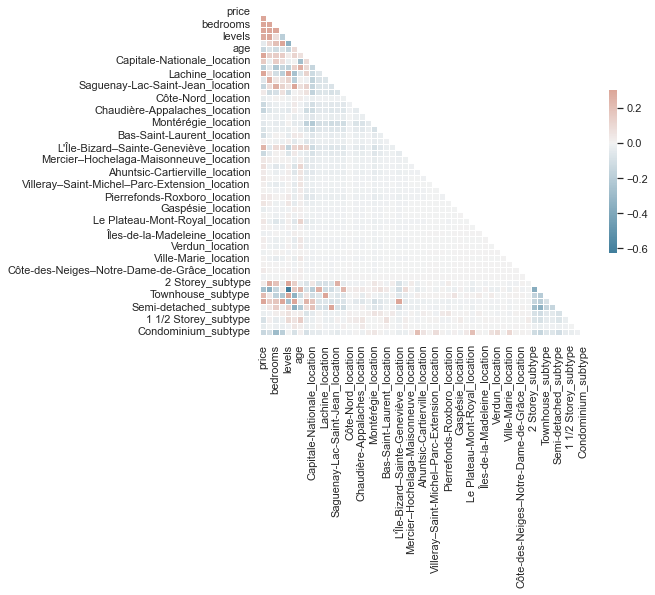

In [381]:
df = X_train.copy()
df.insert(0, 'price', y_train)
plot_corr_map(df)

In [382]:
reg = LinearRegression().fit(X_train, y_train)
reg.score(X_test, y_test)

0.705183615007909

# Neural Net

In [383]:
model = Sequential()
model.add(Dense(units=20, activation='tanh', input_shape=(X_train.shape[-1],)))
model.add(Dense(units=10, activation='tanh'))
model.add(Dense(units=1, activation='linear'))

print(model.summary())

model.compile(optimizer=Adam(lr=0.001), loss='mse')

history = model.fit(X_train, y_train, batch_size=1000, epochs=500, shuffle=True, verbose=1, validation_data=(X_test, y_test))

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_73 (Dense)            (None, 20)                1060      
                                                                 
 dense_74 (Dense)            (None, 10)                210       
                                                                 
 dense_75 (Dense)            (None, 1)                 11        
                                                                 
Total params: 1,281
Trainable params: 1,281
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/500


c:\Users\simon\Documents\GitHub\quebec-real-estate\venv\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


77/77 [==============================] - 0s 2ms/step - loss: 0.0668 - val_loss: 0.0152
Epoch 2/500
77/77 [==============================] - 0s 1ms/step - loss: 0.0114 - val_loss: 0.0091
Epoch 3/500
77/77 [==============================] - 0s 1ms/step - loss: 0.0082 - val_loss: 0.0074
Epoch 4/500
77/77 [==============================] - 0s 1ms/step - loss: 0.0070 - val_loss: 0.0066
Epoch 5/500
77/77 [==============================] - 0s 1ms/step - loss: 0.0064 - val_loss: 0.0062
Epoch 6/500
77/77 [==============================] - 0s 1ms/step - loss: 0.0061 - val_loss: 0.0060
Epoch 7/500
77/77 [==============================] - 0s 1ms/step - loss: 0.0059 - val_loss: 0.0058
Epoch 8/500
77/77 [==============================] - 0s 1ms/step - loss: 0.0057 - val_loss: 0.0057
Epoch 9/500
77/77 [==============================] - 0s 1ms/step - loss: 0.0056 - val_loss: 0.0056
Epoch 10/500
77/77 [==============================] - 0s 1ms/step - loss: 0.0056 - val_loss: 0.0055
Epoch 11/500
77/77 [=

In [384]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

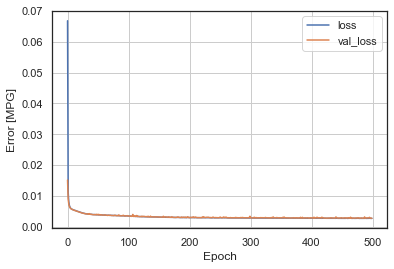

In [385]:
plot_loss(history)

In [386]:
sk_predicted_prices = target_scaler.inverse_transform(reg.predict(X_test))
nnet_predicted_prices = target_scaler.inverse_transform(model.predict(X_test))
real_prices = target_scaler.inverse_transform(y_test)

In [387]:
test_df = X_test.copy()

In [388]:
for col in scaled_cols:
    test_df[col] = scalers[col].inverse_transform(test_df[[col]])

for col in ordinal_cols:
    test_df[col] = ordinal_encoders[col].inverse_transform(test_df[[col]])

In [389]:
d = {}
d['real price'] = list(real_prices)
d['nnet predicted price'] = list(nnet_predicted_prices)
d['sk predicted price'] = list(sk_predicted_prices)

test_df['real price'] = d['real price']
test_df['nnet predicted price'] = d['nnet predicted price']
test_df['sk predicted price'] = d['sk predicted price']

test_df['real price'] = test_df['real price'].astype(int)
test_df['nnet predicted price'] = test_df['nnet predicted price'].astype(int)
test_df['sk predicted price'] = test_df['sk predicted price'].astype(int)

In [390]:
test_df.head(12)

,living_area,bedrooms,bathrooms,levels,yard_area,age,listing_year,Capitale-Nationale_location,Mauricie_location,Lachine_location,...,Townhouse_subtype,Bi-generation_subtype,Semi-detached_subtype,Split Level_subtype,1 1/2 Storey_subtype,Country Home_subtype,Condominium_subtype,real price,nnet predicted price,sk predicted price
71813,1645.0,3.0,1.0,3.0,0.0,15.0,2021.0,0,0,1,...,1,0,0,0,0,0,0,612000,616961,579563
37699,1074.0,3.0,2.0,1.0,6144.0,26.0,2015.0,0,1,0,...,0,0,0,0,0,0,0,225000,173074,236148
33109,1000.0,3.0,2.0,1.0,4490.0,8.0,2016.0,0,0,0,...,0,0,0,0,0,0,0,211500,261527,290579
70393,1645.0,3.0,1.0,3.0,0.0,15.0,2021.0,0,0,1,...,1,0,0,0,0,0,0,612000,616961,579563
53943,1346.0,3.0,1.0,2.0,2206.0,2.0,2010.0,0,0,0,...,0,0,1,0,0,0,0,220000,230911,181162
11801,1119.0,4.0,2.0,1.0,4865.0,57.0,2020.0,1,0,0,...,0,0,0,0,0,0,0,371000,313919,363098
67392,1261.0,2.0,1.0,1.0,8239.0,64.0,2021.0,0,1,0,...,0,0,0,0,0,0,0,265000,265535,222035
4128,2188.0,5.0,3.0,2.0,7812.0,32.0,2021.0,0,1,0,...,0,0,0,0,0,0,0,475000,441921,461286
47813,1120.0,4.0,1.0,1.0,5180.0,48.0,2012.0,1,0,0,...,0,0,0,0,0,0,0,290000,249428,234266
40408,1464.0,2.0,1.0,2.0,3986.0,24.0,2014.0,0,0,0,...,0,0,0,1,0,0,0,315000,269557,242680


In [391]:
errors = abs(nnet_predicted_prices - real_prices)
errors_small = list(filter(lambda x: x < 100000, errors))
errors_pct = 100 * (abs(nnet_predicted_prices - real_prices) / real_prices)
errors_pct_small = list(filter(lambda x: x < 100, errors_pct))

c:\Users\simon\Documents\GitHub\quebec-real-estate\venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

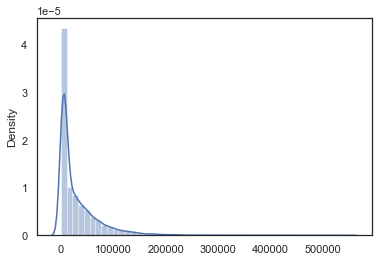

In [392]:
sns.distplot(errors)

c:\Users\simon\Documents\GitHub\quebec-real-estate\venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

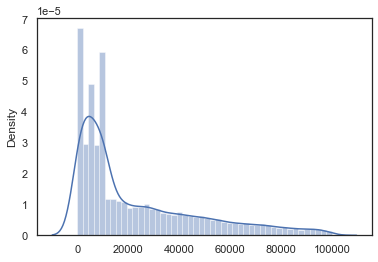

In [393]:
sns.distplot(errors_small)

c:\Users\simon\Documents\GitHub\quebec-real-estate\venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

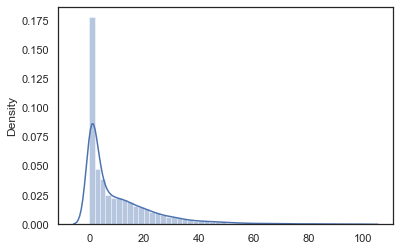

In [394]:
sns.distplot(errors_pct_small)

In [395]:
e_avg = int(np.mean(errors))
e_std = int(np.std(errors))
epct_avg = round(np.mean(errors_pct), 2)
epct_std = round(np.std(errors_pct), 2)

print('Error Mean ($): ' + str(e_avg) + '$')
print('Error std ($): ' + str(e_std) + '$')
print('Error Mean (%): ' + str(epct_avg) + '%')
print('Error std (%): ' + str(epct_std) + '%')

Error Mean ($): 31263$
Error std ($): 41895$
Error Mean (%): 11.89%
Error std (%): 19.15%
